In [26]:
import numpy as np 
import matplotlib.pyplot as plt 
import cv2
import os
import sys 
import random 

# Load image and template


In [27]:
image_path = "Counting/rabbit2.png"
template__folder_path = os.path.join("match_template", image_path[:-4])
template__folder_path

'match_template\\Counting/rabbit2'

In [28]:
def get_template(folder_path: str):
    templates = []
    for file in os.listdir(folder_path):
        template = cv2.imread(os.path.join(folder_path, file))
        templates.append(template)
    return templates



In [29]:
def plot_image(image: np.array, title: str= "", type: str="rgb"):
    if type == "gray":
        plt.imshow(image, cmap="gray")
    else: 
        plt.imshow(image[:, :, ::-1])
    plt.title(title)
    plt.show()  

In [30]:
templates = get_template(template__folder_path)


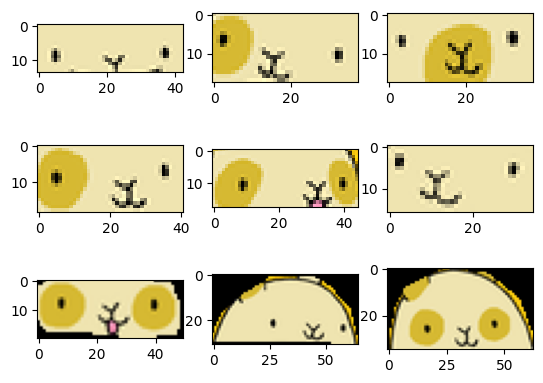

In [31]:
for idx in range(len(templates)):
    plt.subplot(3, 3, idx + 1)
    img = templates[idx]
    # print(img)
    plt.imshow(templates[idx][:, :, ::-1])

In [32]:
image_rgb = cv2.imread(image_path)

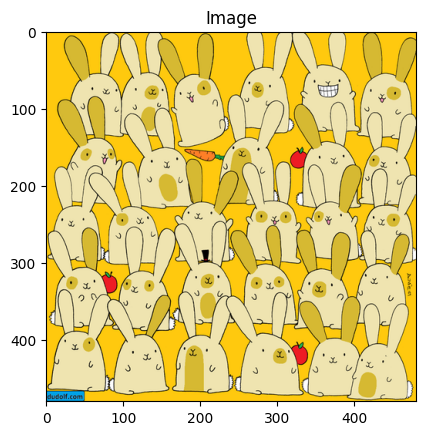

In [33]:
plot_image(image_rgb, "Image")

# Convert to gray

In [34]:
templates_gray = [cv2.cvtColor(template, cv2.COLOR_BGR2GRAY) for template in templates]
image_gray = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2GRAY)


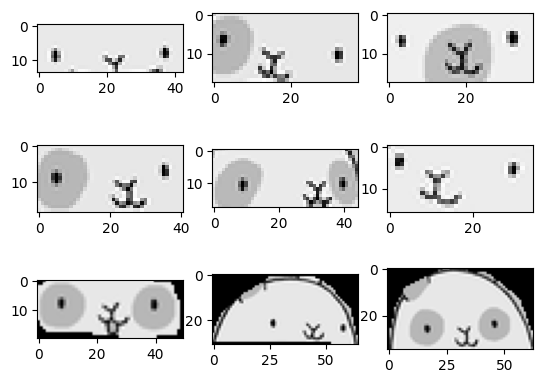

In [35]:
for idx in range(len(templates_gray)):
    plt.subplot(3, 3, idx + 1)
    img = templates_gray[idx]
    # print(img)
    plt.imshow(templates_gray[idx], cmap="gray")

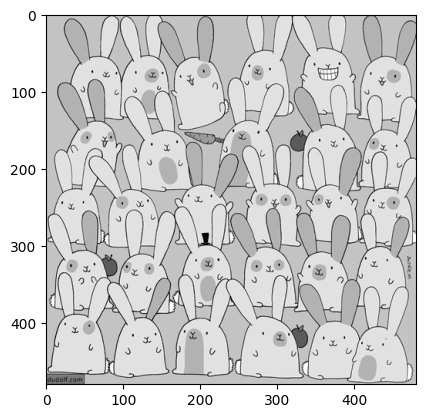

In [36]:
plt.imshow(image_gray, cmap="gray")

# Processing

In [37]:
def eliminate_color(image: np.array):
    """
    Input: gray image 
    
    Output: binary image
    
    Process: 
    detect edge using canny edge detection
    revert the color of the edge
    thresholding
    """
    edges = cv2.Canny(image, 127, 255)
    edges = cv2.GaussianBlur(255 - edges, (3, 3), 0)
    # edges = 255 - edges
    _, binary_img = cv2.threshold(edges, 240, 255, cv2.THRESH_BINARY)
    
    return binary_img
    

In [38]:
def rotate_image(template, angle):
    """Rotate the template by the given angle."""
    height, width = template.shape[:2]
    center = (width // 2, height // 2)
    
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(template, rotation_matrix, (width, height), flags=cv2.INTER_LINEAR)
    
    return rotated

In [39]:
def image_addition(images: list):
    """Add all images in the list"""
    res_w = max(image.shape[1] for image in images)
    res_h = max(image.shape[0] for image in images)
    res = np.zeros((res_h, res_w), np.uint8)
    for image in images:
        res[:image.shape[0], :image.shape[1]] += image
    return res

In [40]:
added_template = image_addition(templates_gray[1:4])

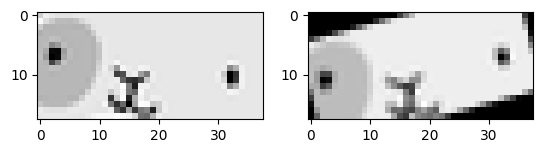

In [41]:
### check totate image
check_template = templates_gray[1]
rotated_template = rotate_image(check_template, 15)
plt.subplot(1, 2, 1)
plt.imshow(check_template, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(rotated_template, cmap="gray")


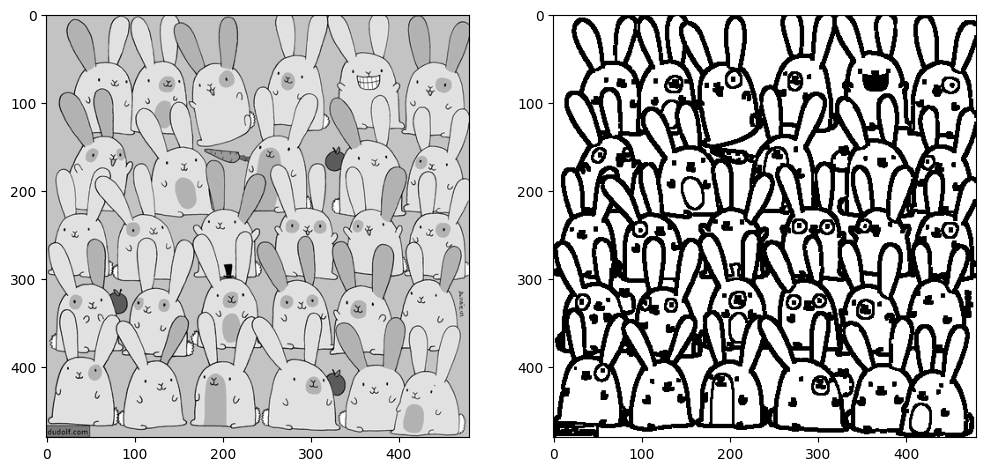

In [42]:
# check convert to binary image
processed_image = eliminate_color(image_gray)

plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(image_gray, cmap="gray")

plt.subplot(122)
plt.imshow(processed_image, cmap="gray")

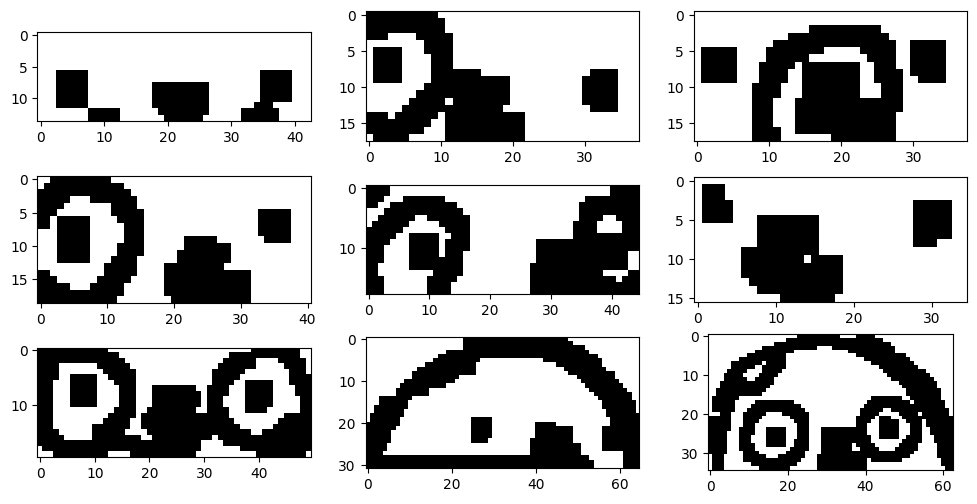

In [43]:
processed_template = [eliminate_color(template) for template in templates_gray]
plt.figure(figsize=(12, 6))
for idx in range(len(processed_template)):
    plt.subplot(3, 3, idx + 1)
    plt.imshow(processed_template[idx], cmap="gray")

# Template matching

In [44]:
def check_overlap(box1, box2, overlap_threshold=0.5):
    """
    Input:
    box1: Tuple (x1, y1, w1, h1) of the first bounding box
    box2: Tuple (x2, y2, w2, h2) of the second bounding box
    """
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    
    # Calculate the coordinates of the intersection rectangle
    x_left = max(x1, x2)
    y_top = max(y1, y2)
    x_right = min(x1 + w1, x2 + w2)
    y_bottom = min(y1 + h1, y2 + h2)
    
    # Check if there is an intersection
    if x_right < x_left or y_bottom < y_top:
        return False
    
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    
    # Calculate the area of the first bounding box
    box1_area = w1 * h1
    
    # Calculate the overlap ratio
    overlap_ratio = intersection_area / box1_area
    
    # Return True if the overlap ratio is greater than or equal to the threshold
    return overlap_ratio >= overlap_threshold

In [45]:
def find_bounding_boxs(image: np.array, templates: np.array, selecting_threshold: float=0.95, plot_match_map: bool=False, title: str=""):
    check = [] 
    if plot_match_map:
        plt.figure(figsize=(12, 6))
        plt.title(title)
    for idx in range(len(templates)): 
        # print(template.shape)
        template = templates[idx]
        h, w = template.shape[:2]
        res = cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)
        if plot_match_map:
            plt.subplot(3, 3, idx + 1)
            plt.imshow(res, cmap="gray")
            
        
        # res = cv2.matchTemplate(image, template, cv2.TM_CCORR_NORMED)
        
        if selecting_threshold > 0 and selecting_threshold < 1: 
            threshold = sorted(res.flatten())[int(0.95 * len(res.flatten()))]
        else:
            threshold = sorted(res.flatten())[selecting_threshold]
        loc = np.where(res >= threshold)
        
        x, y = loc[::-1]  
        for i in range(len(x)):
            score = res[y[i], x[i]]
            check.append((score, x[i], y[i], w, h))
        
    return check
    

In [46]:
def convert_image_template(image: np.array, templates: list[np.array], covert_type: str="binary", convert_param: tuple= None):
    """
    Convert the image by given type (binary, flip,...)
    """
    if covert_type == "binary":
        processed_image = eliminate_color(image)
        processed_templates = [eliminate_color(template) for template in templates]
    elif covert_type == "flip":
        processed_image = image
        processed_templates = [cv2.flip(template, convert_param) for template in templates]
        # processed_image = eliminate_color(image)
        # processed_templates = [eliminate_color(template) for template in processed_templates]
    elif covert_type == "rotate":
        processed_image = image
        processed_templates = [rotate_image(template, convert_param) for template in templates]
        # processed_image = eliminate_color(image)
        # processed_templates = [eliminate_color(template) for template in processed_templates]
    else: 
        return None 
    return processed_image, processed_templates

In [47]:
def plot(images, title= ""):
        if isinstance(images, list):
            plt.figure(figsize=(12, 6))
            for idx in range(len(images)):
                plt.subplot(3, 3, idx + 1)
                plt.imshow(images[idx], cmap="gray")
                plt.title(title)
            plt.show()
        else:
            plt.imshow(images, cmap="gray")
            plt.title(title)
            plt.show()

In [48]:
def recalculate_score_with_square_error(bboxes: list[tuple], image: np.array, templates: list[np.array]):
    mse = []
    for box in bboxes:
        x, y, w, h = box[1:]
        check_template = None
        for template in templates:
            if template.shape[0] == h and template.shape[1] == w:
                check_template = template
                break
        if check_template is None:
            mse.append(0)
        
        else:
            try:
                mse.append(np.sum(image[y: y + h, x: x + w] - check_template)**2)
                # print(w,h )
            except Exception as e:
                print(e)
                print(w, h)
                print(check_template.shape)
                print(processed_image.shape)
        
    mse = np.array(mse)
    mse = mse / np.linalg.norm(mse, np.inf) # max
    for i in range(len(bboxes)):
        bboxes[i] = ((mse[i] + bboxes[i][0])/2, bboxes[i][1], bboxes[i][2], bboxes[i][3], bboxes[i][4])
    return bboxes

In [49]:
def apply_templates(image, templates, original_image= None, 
                    plot_processed_image= True, convert_config: list = None, convert_param: list = None,
                    selecting_threshold= 0.95, overlap_threshold=0.5,
                    plot_match_map= False, bounding_box_threshold=0.7):
    """
    Input: 
    image: np.array of the image (gray or rgb)
    templates: list of np.array of the templates (gray or rgb)
    original_image: np.array of the original image (rgb)
    plot_processed_image: bool to plot the processed image
    convert_config: list of str of the convert type (binary, flip, rotate)
    convert_param: list of tuple of the convert parameter for converting the image
    selecting_threshold: the precentage of eliminate the low score bounding box or - number of taken bounding box
    overlap_threshold: the threshold of the overlap ratio between two bounding box
    plot_match_map: bool to plot the match map of the templates
    bounding_box_threshold: the percentage of eliminate bounding box
    """
    
            
    ## get all possible bounding boxes
    ####################
    if plot_processed_image:
        plot(templates, title= "Gray Templates")
    
    bboxes = []
    bboxes.extend(find_bounding_boxs(image, templates, selecting_threshold, plot_match_map= plot_match_map, title= "Gray Match Map"))
    if convert_config is not None:
        for convert_type, convert_param in zip(convert_config, convert_param):
            processed_image, processed_templates = convert_image_template(image, templates, convert_type, convert_param)
            new_bboxes = find_bounding_boxs(processed_image, processed_templates, selecting_threshold, plot_match_map= plot_match_map, title= convert_type + " Match Map")
            
            # recalculate bounding box_score by square error
            if convert_type == "binary":  
                new_bboxes = recalculate_score_with_square_error(new_bboxes, image, templates)
            # if convert_type == "flip":  
            #     new_bboxes = recalculate_score_with_square_error(new_bboxes, image, processed_templates)
                
            
            bboxes.extend(new_bboxes)
            if plot_processed_image:
                plot([image, processed_image], "Original and Processed Image " + convert_type)
                plot(processed_templates, title= "Processed Templates " + convert_type)
    else:
        plot(image, "Original Image")
    

    # sort the bounding boxes 
    check = sorted(bboxes, key=lambda x: x[0], reverse=True)
    # print(len(check))
    
    ## reduce the bounding boxes
    ##############################
    #check overlap
    bb_res = []
    for i in range(len(check)):
        if len(bb_res) == 0:
            bb_res.append(check[i])
        else:
            flag = True
            for box in bb_res:
                if check_overlap(box[1:], check[i][1:], overlap_threshold):
                    flag = False
                    break
            if flag:
                bb_res.append(check[i])
                
    ## eliminate by quality threshold
    mean_score = np.mean([x[0] for x in bb_res])
    print("lowest score: ", bb_res[-1][0])
    print("highest score: ", bb_res[0][0])
    print("mean score: ", mean_score)
    score_threshold = bb_res[int((1 - bounding_box_threshold) * len(bb_res))][0]
    print("score threshold: ", score_threshold)
    bb_res = [x for x in bb_res if x[0] > score_threshold]
    
    
    #############plot the bounding box
    
    bb_res = [x[1:] for x in bb_res]
    if original_image is not None:
        res_image = original_image.copy()
        for bb in bb_res:
            cv2.rectangle(res_image, bb[:2], (bb[0] + bb[2], bb[1] + bb[3]), (0,0,255), 2)
            
        plt.figure(figsize=(12, 6))
        plt.imshow(res_image[:, :, ::-1])
        plt.title(f"Counting Result : {len(bb_res)}")
        for idx in range(len(bb_res)):
            bb = bb_res[idx]
            plt.annotate(str(idx + 1), (bb[0] - 10 , bb[1] + 10), color="yellow", fontsize=15)
    return bb_res
    

lowest score:  0.20857052599101944
highest score:  1.0
mean score:  0.3946985085979429
score threshold:  0.48300985


36

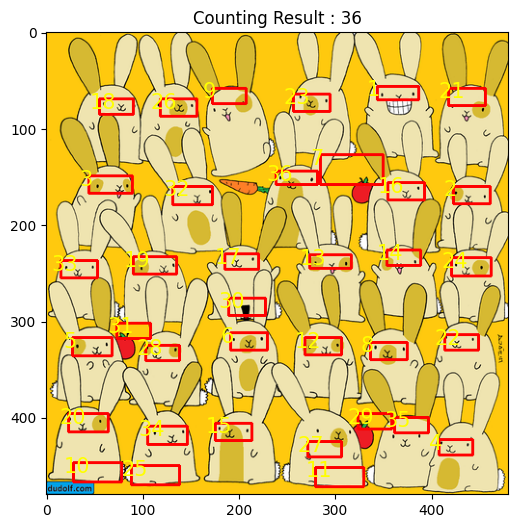

In [54]:
convert_config = ["binary", "flip", 'rotate', 'rotate']
convert_param = [None, 1, -30, 30]
# convert_config = ["binary", "flip"]
# convert_param = [None, 1]
bb= apply_templates(image_gray,templates_gray,original_image= image_rgb, plot_processed_image= False, selecting_threshold= -300,
                    overlap_threshold= 0.1, plot_match_map= False, bounding_box_threshold= 0.8, convert_config= convert_config, convert_param= convert_param)
len(bb)

lowest score:  0.21961118914760686
highest score:  1.0
mean score:  0.4087214925949506
score threshold:  0.48784018


34

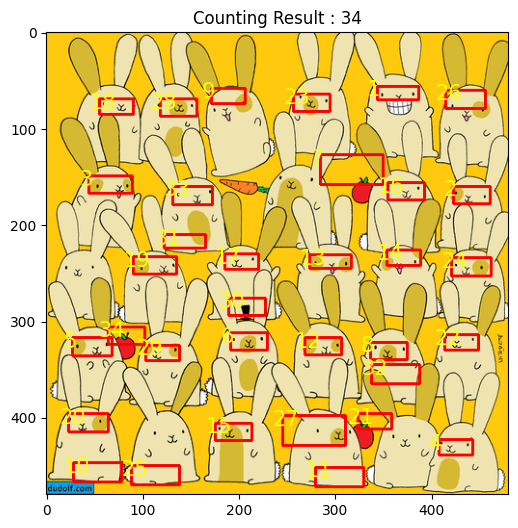

In [29]:
convert_config = ["binary", "flip", 'rotate', 'rotate']
convert_param = [None, 1, -35, 35]
# convert_config = ["binary", "flip"]
# convert_param = [None, 1]
bb= apply_templates(image_gray,templates_gray,original_image= image_rgb, plot_processed_image= False, selecting_threshold= -300,
                    overlap_threshold= 0.05, plot_match_map= False, bounding_box_threshold= 0.78, convert_config= convert_config, convert_param= convert_param)
len(bb)

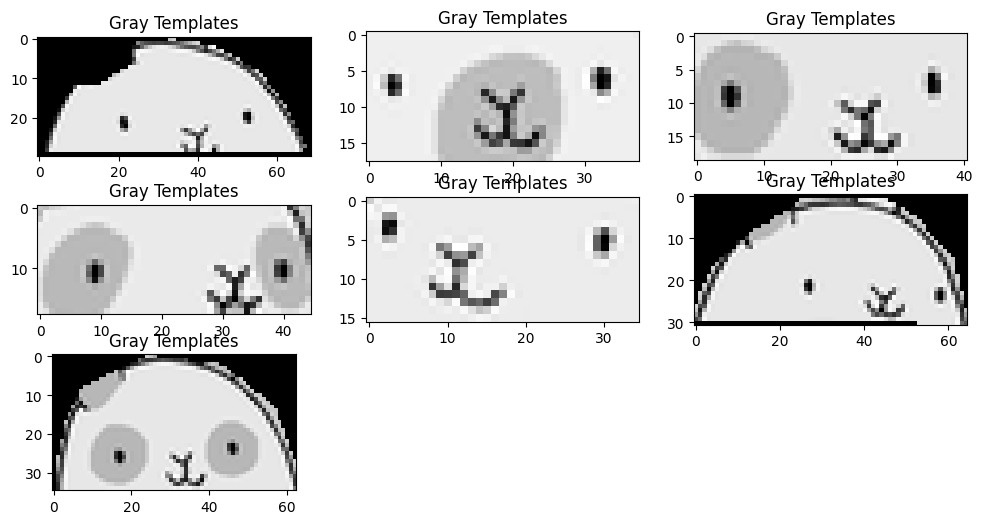

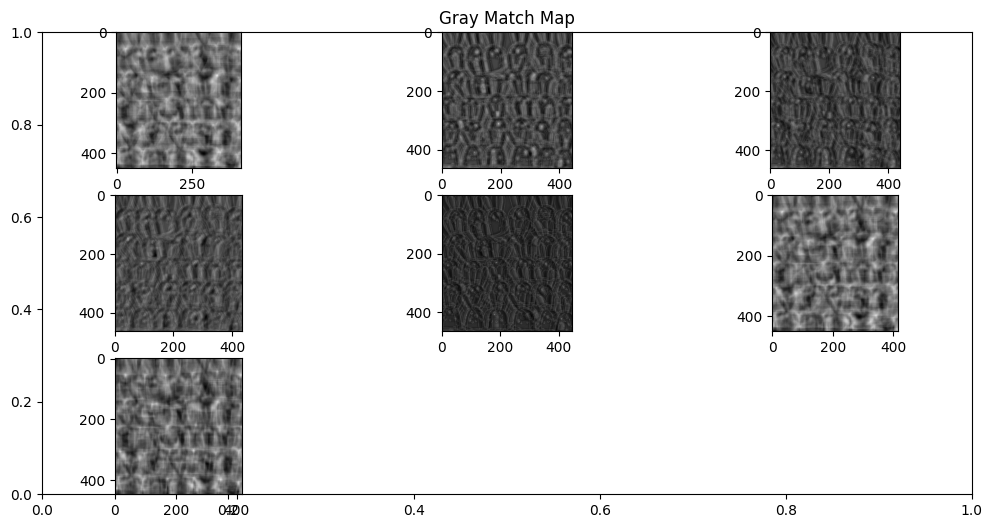

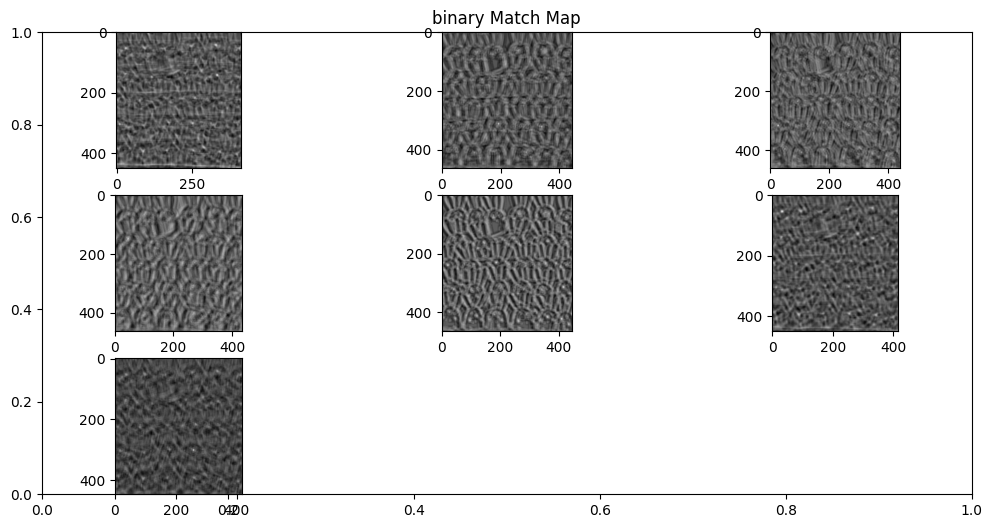

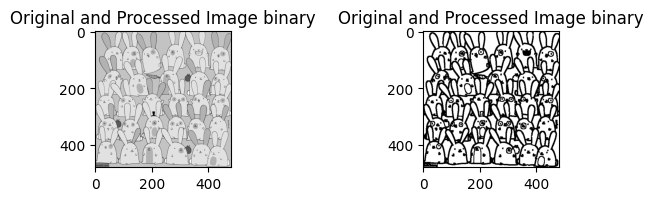

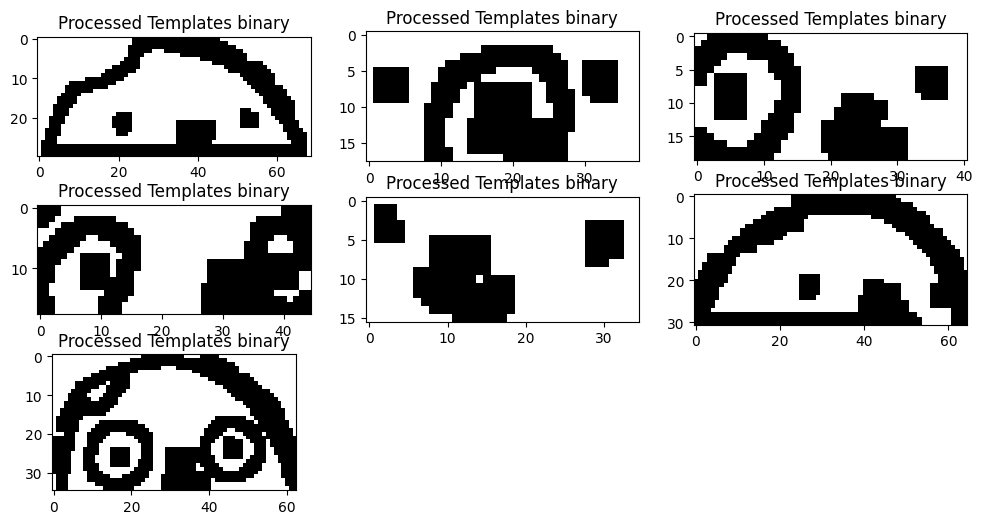

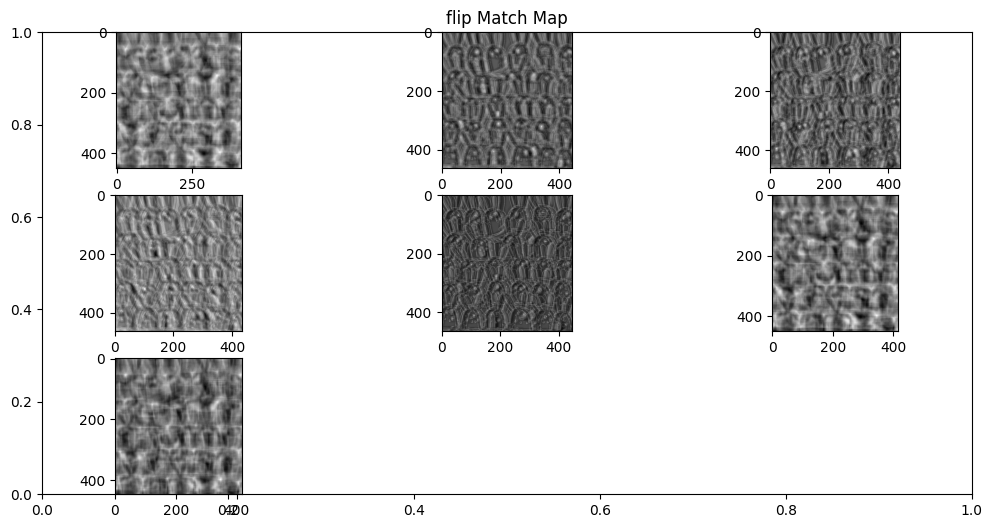

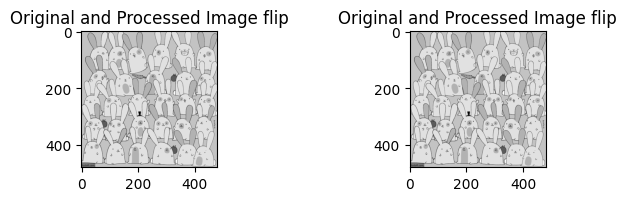

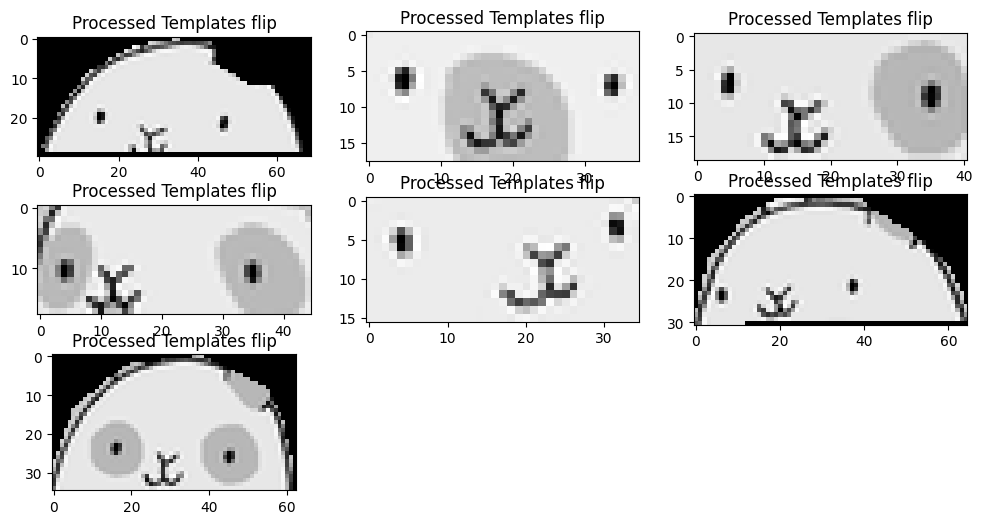

lowest score:  0.21624790441603484
highest score:  1.0
mean score:  0.4039981166361642
score threshold:  0.35415018


60

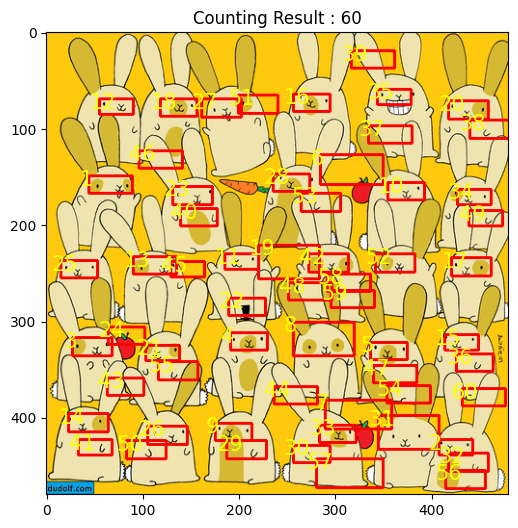

In [51]:
convert_config = ["binary", "flip"]
convert_param = [None, 1]
bb= apply_templates(image_gray,templates_gray,original_image= image_rgb, plot_processed_image= True, selecting_threshold= -200,
                    overlap_threshold= 0.1, plot_match_map= True, bounding_box_threshold= 0.5, convert_config= convert_config, convert_param= convert_param)
len(bb)

In [52]:
def test_bb(bb: list, image):
    """ 
    check random 5 bb"""
    res_image = image.copy()
    check_bb = random.sample(bb, 5)
    for box in check_bb:
        cv2.rectangle(res_image, box[:2], (box[0] + box[2], box[1] + box[3]), (0,0,255), 2)
    plt.imshow(res_image[:, :, ::-1])